# CNN

## Notebook's Environment

In [1]:
INSTALL_DEPS = False
if INSTALL_DEPS:
  %pip install matplotlib==3.8.3
  %pip installnumpy==1.26.4
  %pip installpandas==2.2.1
  %pip installpandas_market_calendars==4.4.0
  %pip installpytz==2024.1
  %pip installscipy==1.12.0
  %pip installta==0.11.0
  %pip installyfinance==0.2.37

!python --version

Python 3.11.8


## Cloud Environment Setup

In [2]:
import os
import sys
import warnings

warnings.filterwarnings("ignore")

IN_KAGGLE = IN_COLAB = False
try:
    # https://www.tensorflow.org/install/pip#windows-wsl2
    import google.colab
    from google.colab import drive

    drive.mount("/content/drive")
    DATA_PATH = "/content/drive/MyDrive/EDT dataset"
    MODEL_PATH = "/content/drive/MyDrive/models"
    IN_COLAB = True
    print("Colab!")
except:
    IN_COLAB = False
if "KAGGLE_KERNEL_RUN_TYPE" in os.environ and not IN_COLAB:
    print("Running in Kaggle...")
    for dirname, _, filenames in os.walk("/kaggle/input"):
        for filename in filenames:
            print(os.path.join(dirname, filename))
    MODEL_PATH = "./models"
    DATA_PATH = "/kaggle/input/"
    IN_KAGGLE = True
    print("Kaggle!")
elif not IN_COLAB:
    IN_KAGGLE = False
    MODEL_PATH = "./models"
    DATA_PATH = "./data/"
    print("running localhost!")

running localhost!


In [3]:
import tensorflow as tf
from tensorflow.keras import mixed_precision

print(f'Tensorflow version: [{tf.__version__}]')

tf.get_logger().setLevel('INFO')

#tf.config.set_soft_device_placement(True)
#tf.config.experimental.enable_op_determinism()
#tf.random.set_seed(1)
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
except Exception as e:
  # Not an exception, just no TPUs available, GPU is fallback
  # https://www.tensorflow.org/guide/mixed_precision
  print(e)
  policy = mixed_precision.Policy('mixed_float16')
  mixed_precision.set_global_policy(policy)
  gpus = tf.config.experimental.list_physical_devices('GPU')
  if len(gpus) > 0:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, False)
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=12288)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        strategy = tf.distribute.MirroredStrategy()

        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
    finally:
        print("Running on", len(tf.config.list_physical_devices('GPU')), "GPU(s)")
  else:
    # CPU is final fallback
    strategy = tf.distribute.get_strategy()
    print("Running on CPU")

def is_tpu_strategy(strategy):
    return isinstance(strategy, tf.distribute.TPUStrategy)

print("Number of accelerators:", strategy.num_replicas_in_sync)
os.getcwd()

2024-05-30 17:42:05.212111: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-30 17:42:05.862859: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-30 17:42:05.862906: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-30 17:42:06.013692: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-30 17:42:06.322879: I tensorflow/core/platform/cpu_feature_guar

Tensorflow version: [2.15.1]
Please provide a TPU Name to connect to.
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


2024-05-30 17:42:10.980207: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-30 17:42:11.149916: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-30 17:42:11.149960: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-30 17:42:11.150638: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-30 17:42:11.155241: I external/local_xla/xla/stream_executor

1 Physical GPUs, 1 Logical GPUs
Running on 1 GPU(s)
Number of accelerators: 1


'/mnt/c/Users/adamd/workspace/intra_day_futures_arb'

# Instruments

In [4]:
from constants import *

FEATURES_SELECTED = ['10Y_Barcount', '10Y_Spread', '10Y_Volume', '2YY_Spread', '2YY_Volume',
                    'CONTRA', 'Filtered_X', 'KG_X', 'KG_Z1', 'RTY_Spread', 'SD', 'Spread',
                    'TSMOM', 'VXM_Open', 'VXM_Spread', 'Volume']
TARGET_FUT, INTERVAL

('ZC', '15m')

## Data Load

In [5]:
import pandas as pd
import numpy as np

filename = f"{DATA_PATH}{os.sep}futures_{INTERVAL}.csv"
print(filename)
futs_df = pd.read_csv(filename, index_col="Date", parse_dates=True)

print(futs_df.shape)
futs_df.head(2)

./data//futures_15m.csv
(1938, 128)


,10Y_Open,10Y_High,10Y_Low,10Y_Close,10Y_Volume,10Y_Barcount,10Y_Average,10Y_Spread,2YY_Open,2YY_High,...,ZS_Average,ZS_Spread,ZW_Open,ZW_High,ZW_Low,ZW_Close,ZW_Volume,ZW_Barcount,ZW_Average,ZW_Spread
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-29 15:30:00+00:00,3.883,3.883,3.86,3.860,95.0,48.0,3.8709,0.023,4.184,4.184,...,1308.375,5.0,630.25,632.00,626.25,629.50,3081.0,1133.0,628.7,5.75
2023-12-29 15:45:00+00:00,3.860,3.878,3.86,3.875,18.0,14.0,3.8722,0.018,4.184,4.184,...,1304.325,3.5,629.75,631.25,628.75,629.25,996.0,468.0,630.1,2.50


In [6]:
from quant_equations import get_ou, get_annualized_factor, calc_annualized_sharpe, deflated_sharpe_ratio

HALF_LIFE, HURST = get_ou(futs_df, f'{TARGET_FUT}_Close')

print("Half-Life:", HALF_LIFE)
print("Hurst:", HURST)

Half-Life: 135
Hurst: 0.5093391169683746


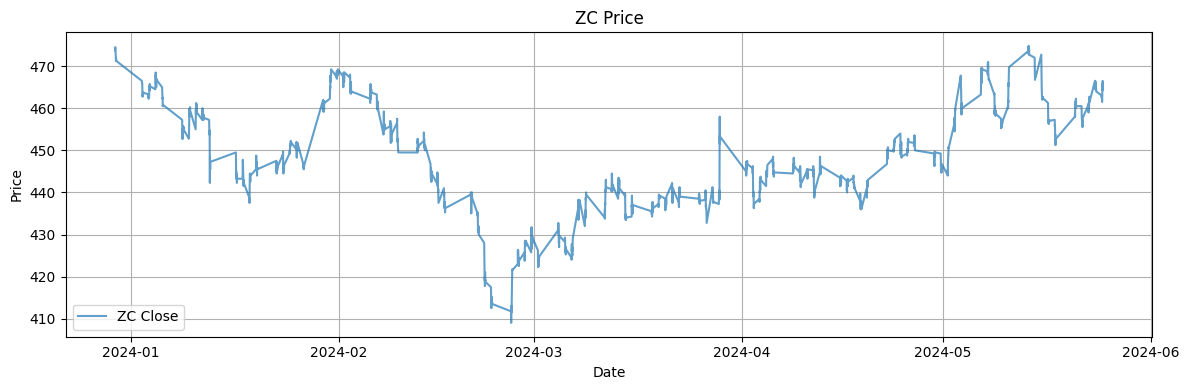

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.plot(futs_df[f'{TARGET_FUT}_Close'], label=f'{TARGET_FUT} Close', alpha=0.7)
plt.title(f'{TARGET_FUT} Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Prepare the Data

In [8]:
from models import process_futures, process_exog
import pickle

TEST_SPLIT = 0.6
TRAIN_SIZE = int(len(futs_df) * TEST_SPLIT)
CACHE = True
FUTURES_TMP_FILE = "./tmp/futures.pkl"

with strategy.scope():
    if not os.path.exists(FUTURES_TMP_FILE):
        futs_exog_df = process_exog(MARKET_FUTS, futs_df)
        train_agri_ts, val_agri_ts, scalers = process_futures(FUTS, futs_df, futs_exog_df, TRAIN_SIZE, INTERVAL)
        if CACHE:
            pickle.dump(train_agri_ts, FUTURES_TMP_FILE)
    else:
        train_agri_ts = pickle.load(FUTURES_TMP_FILE)

# Stacking the lists of dataframes into single dataframes
# train_ts_df = pd.concat([df.reset_index(drop=True) for df in train_agri_ts], axis=0, ignore_index=True).dropna()
# test_ts_df = pd.concat([df.reset_index(drop=True) for df in val_agri_ts], axis=0, ignore_index=True).dropna()

# test_ts_df.tail(5)

100%|██████████| 1046/1046 [00:00<00:00, 2932.77it/s]
kalman_backtest: 1046it [00:00, 7876.23it/s]
100%|██████████| 699/699 [00:00<00:00, 3190.59it/s]
kalman_backtest: 699it [00:00, 8127.53it/s]
100%|██████████| 1046/1046 [00:00<00:00, 3073.93it/s]
kalman_backtest: 1046it [00:00, 9283.12it/s]
100%|██████████| 699/699 [00:00<00:00, 2907.68it/s]
kalman_backtest: 699it [00:00, 9045.95it/s]
100%|██████████| 1046/1046 [00:00<00:00, 2997.56it/s]
kalman_backtest: 1046it [00:00, 8384.17it/s]
100%|██████████| 699/699 [00:00<00:00, 2628.89it/s]
kalman_backtest: 699it [00:00, 7484.30it/s]
100%|██████████| 1046/1046 [00:00<00:00, 2992.66it/s]
kalman_backtest: 1046it [00:00, 8488.16it/s]
100%|██████████| 699/699 [00:00<00:00, 3168.55it/s]
kalman_backtest: 699it [00:00, 9299.80it/s]
100%|██████████| 1046/1046 [00:00<00:00, 3142.35it/s]
kalman_backtest: 1046it [00:00, 7682.31it/s]
100%|██████████| 699/699 [00:00<00:00, 2444.43it/s]
kalman_backtest: 699it [00:00, 6251.15it/s]
100%|██████████| 1046/104

TypeError: file must have a 'write' attribute

In [ ]:
from models import aug_metalabel_mr, META_LABEL
from tqdm import tqdm

PREDICTION_HORIZON = 1
WINDOW  = HALF_LIFE
WINDOW_TMP_PATH = "./tmp/"

def prepare_windows(
    data_df,
    label_df,
    window_size=WINDOW,
    horizon=PREDICTION_HORIZON,
):
    assert len(data_df) > 1
    X, y = [], []
    for i in tqdm(
        range(len(data_df) - window_size - horizon + 1), desc=f"Encoding Widows of {window_size} with {horizon} horizon."
    ):
        input_window = data_df.iloc[i : i + window_size].values
        X.append(input_window)
        if label_df is not None:
            target_window = label_df.iloc[i + window_size : i + window_size + horizon].values
            y.append(target_window)

    return np.array(X),  np.array(y)

def prepare_windows_with_disjoint_ts(
    ts_list,
    window_size=WINDOW,
    horizon=PREDICTION_HORIZON,
):
    Xs, ys = [], []

    # Iterate over each disconnected time series and build windows there.
    for data_df in ts_list:
        assert len(data_df) > 1
        data_df = aug_metalabel_mr(data_df)
        X, y = prepare_windows(data_df[FEATURES_SELECTED], data_df[META_LABEL], window_size=window_size, horizon=horizon)

        Xs.append(X)
        ys.append(y)

    Xs = np.array(Xs)
    ys = np.array(ys)
    Xs = np.concatenate(Xs, axis=0)
    ys = np.concatenate(ys, axis=0)
    return Xs,  ys

with strategy.scope():
    if not os.path.exists(WINDOW_TMP_PATH):
        X, y = prepare_windows_with_disjoint_ts(train_agri_ts)
        X_t, y_t = prepare_windows_with_disjoint_ts(val_agri_ts)
        if CACHE:
            pickle.dump(X, WINDOW_TMP_PATH + "X.pkl")
            pickle.dump(y, WINDOW_TMP_PATH + "y.pkl")
            pickle.dump(X_t, WINDOW_TMP_PATH + "X_t.pkl")
            pickle.dump(y_t, WINDOW_TMP_PATH + "y_t.pkl")
    else:
        X = pickle.load(WINDOW_TMP_PATH + "X.pkl")
        y = pickle.load(WINDOW_TMP_PATH + "y.pkl")
        X_t = pickle.load(WINDOW_TMP_PATH + "X_t.pkl")
        y_t = pickle.load(WINDOW_TMP_PATH + "y_t.pkl")

print(f"shapes: {X.shape} and {y.shape}")
X_t[0], y_t[0]

# CNN Architecture

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    SpatialDropout1D,
    Dense,
    Conv1D,
    Layer,
    Add,
    Input,
    Concatenate,
    Flatten,
)
from tensorflow.keras import Model
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

MODEL_NAME = "WAVENET"
EPOCHS = 300
PATIENCE_EPOCHS = 15
# TPU see: https://github.com/tensorflow/tensorflow/issues/41635
BATCH_SIZE = 8  * strategy.num_replicas_in_sync # Default 8
MIN_FILTER = HALF_LIFE + 2
MIN_DENSE = HALF_LIFE
FILTERS = [MIN_FILTER, MIN_FILTER*2]
HIDDEN_DENSE = [MIN_DENSE]
BIAS = True
DROPRATE = 0.5
POOL_SIZE = 5
KERNEL_SIZE = HALF_LIFE
DILATION_RATE = 1
REG_WEIGHTS = 0.02


tf.keras.saving.get_custom_objects().clear()

@tf.keras.saving.register_keras_serializable()
class ConvBlock(Layer):
    """
    CNN Residual Block that uses zero-padding to maintain `steps` value of the ouput equal to the one in the input.
    Residual Block is obtained by stacking togeather (2x) the following:
        - 1D Dilated Convolution
        - ReLu
        - Spatial Dropout
    And adding the input after trasnforming it with a 1x1 Conv
    """

    def __init__(
        self,
        filters=1,
        kernel_size=2,
        dilation_rate=1,
        kernel_initializer="glorot_normal",
        bias_initializer="glorot_normal",
        kernel_regularizer=None,
        bias_regularizer=None,
        use_bias=False,
        dropout_rate=0.0,
        layer_id=None,
        **kwargs,
    ):
        super(ConvBlock, self).__init__(**kwargs)
        assert dilation_rate is not None and dilation_rate > 0 and filters > 0 and kernel_size > 0

        self.filters = filters
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.kernel_regularizer = kernel_regularizer
        self.bias_regularizer = bias_regularizer
        self.use_bias = use_bias
        self.dropout_rate = dropout_rate
        self.layer_id = str(layer_id)

    def get_config(self):
        config = super(ConvBlock, self).get_config()
        config.update({
            'filters': self.filters,
            'kernel_size': self.kernel_size,
            'dilation_rate': self.dilation_rate,
            'kernel_initializer': self.kernel_initializer,
            'bias_initializer': self.bias_initializer,
            'kernel_regularizer': self.kernel_regularizer,
            'bias_regularizer': self.bias_regularizer,
            'use_bias': self.use_bias,
            'dropout_rate': self.dropout_rate,
        })
        return config

    def build(self, inputs):
        self.conv1 = Conv1D(
            filters=self.filters,
            kernel_size=self.kernel_size,
            use_bias=self.use_bias,
            bias_initializer=self.bias_initializer,
            bias_regularizer=self.bias_regularizer,
            kernel_initializer=self.kernel_initializer,
            kernel_regularizer=self.kernel_regularizer,
            padding="causal",
            dilation_rate=self.dilation_rate,
            activation="relu",
            name=f"Conv1D_1_{self.layer_id}"
        )
        # Spatial dropout is specific to convolutions by dropping an entire timewindow,
        # not to rely too heavily on specific features detected by the kernels.
        self.dropout1 = SpatialDropout1D(
            self.dropout_rate, trainable=True, name=f"SpatialDropout1D_1_{self.layer_id}"
        )
        # Capture a higher order feature set from the previous convolution
        self.conv2 = Conv1D(
            filters=self.filters,
            kernel_size=self.kernel_size,
            use_bias=self.use_bias,
            bias_initializer=self.bias_initializer,
            bias_regularizer=self.bias_regularizer,
            kernel_initializer=self.kernel_initializer,
            kernel_regularizer=self.kernel_regularizer,
            padding="causal",
            dilation_rate=self.dilation_rate,
            activation="relu",
            name=f"Conv1D_2_{self.layer_id}"
        )
        self.dropout2 = SpatialDropout1D(
            self.dropout_rate, trainable=True, name=f"SpatialDropout1D_2_{self.layer_id}"
        )
        # The skip connection is an addition of the input to the block with the output of the second dropout layer.
        # Solves vanishing gradient, carries info from earlier layers to later layers, allowing gradients to flow across this alternative path.
        # Does not learn direct mappings, but differences (residuals) while keeping temporal context.
        # Note how it keeps dims intact with kernel 1.
        self.skip_out = Conv1D(
            filters=self.filters,
            kernel_size=1,
            activation="linear",
            padding="same",
            name=f"Conv1D_skipconnection_{self.layer_id}",
        )
        # This is the elementwise add for the residual connection and Conv1d 2's output
        self.residual_out = Add(name=f"residual_Add_{self.layer_id}")

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.dropout2(x)

        # Residual output by adding the inputs back
        skip_out_x = self.skip_out(inputs)
        x = self.residual_out([x, skip_out_x])
        return x, skip_out_x


def CNN(
    input_shape,
    dense_units=None,
    output_horizon=PREDICTION_HORIZON,
    filters=[MIN_FILTER],
    kernel_size=KERNEL_SIZE,
    dilation_rate=DILATION_RATE,
    kernel_regularizer=None,
    bias_regularizer=None,
    use_bias=False,
    dropout_rate=DROPRATE,
):
    """
    Tensorflow CNN Model builder.
    see: https://www.tensorflow.org/api_docs/python/tf/keras/Model
    see: https://www.tensorflow.org/guide/keras/making_new_layers_and_models_via_subclassing#the_model_class
    see: https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/L2
    """
    main_input = Input(shape=input_shape, name="main_input")
    x = main_input
    skip_connections = []
    for i, filter in enumerate(filters):
        x, x_skip = ConvBlock(
            filters=filter,
            kernel_size=kernel_size,
            dilation_rate=dilation_rate ** (i + 1),
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
            use_bias=use_bias,
            dropout_rate=dropout_rate,
            layer_id=i,
        )(x)
        skip_connections.append(x_skip)
    if skip_connections:
        skip_connections.append(x)
        aggregated = Concatenate(axis=-1, name=f"Final_Residuals")(skip_connections)
        aggregated = Conv1D(filters[-1], kernel_size=1, activation="linear", padding='same')(aggregated)
    if dense_units:
        # Dense networks for deep learning ifrequired.
        x = Flatten()(x)
        # First layer
        x = Dense(dense_units[0], input_shape=input_shape, activation="tanh", name=f"Dense_0")(x)
        for i, units  in enumerate(dense_units, start=1):
            x = Dense(units , activation="tanh", name=f"Dense__{i}")(x)
        # Last layer - Logits output
        x = Dense(output_horizon, activation=None, name=f"Dense_Classifier")(x)
    else:
        x = Conv1D(filters=output_horizon, kernel_size=1, padding="causal", activation=None, name=f"Conv_Classifier")(x)

    model = Model(
        inputs=[main_input],
        outputs=x,
        name=MODEL_NAME,
    )
    return model

## Training

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.losses import BinaryFocalCrossentropy
from tensorflow.keras.metrics import AUC, BinaryAccuracy

with strategy.scope():
    MODEL_DIR = f"models/{MODEL_NAME}"
    IMAGES_DIR = f"images/{MODEL_NAME}/images"
    LOG_BASEPATH = f"logs/{MODEL_NAME}/tb"

    weights = compute_class_weight(class_weight="balanced", classes=np.unique(y.flatten()), y=y.flatten().flatten())
    CLASS_WEIGHTS = {0: weights[0], 1: weights[1]}
    LEARN_RATE = 0.001
    ERROR_ALPHA = 0.6 # 0.5 > gives more weight to positive class errors. The weight for class 0 is 1.0 - alpha.
    ERROR_GAMMA = 0.8 # focal factor" to down-weight easy examples loss contribution. 0 > focus on hard examples.
    TARGET_METRIC = "auc"
    # https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryFocalCrossentropy
    LOSS = BinaryFocalCrossentropy(apply_class_balancing=False, from_logits=True, alpha=ERROR_ALPHA, gamma=ERROR_GAMMA, name='fbce', reduction="auto")
    # https://www.tensorflow.org/api_docs/python/tf/keras/metrics/BinaryAccuracy
    METRICS = [BinaryAccuracy(name='ba'), AUC(name=TARGET_METRIC, from_logits=True)]

    def build_cnn(
        input_shape,
        X, y,
        Xt=None, yt=None,
        output_horizon= PREDICTION_HORIZON,
        filters= FILTERS,
        kernel_size= KERNEL_SIZE,
        dilation_rate= DILATION_RATE,
        kernel_regularizer=L1L2(l1= REG_WEIGHTS, l2=REG_WEIGHTS//10),
        bias_regularizer=L1L2(l1= REG_WEIGHTS, l2=REG_WEIGHTS//10),
        dropout_rate=DROPRATE,
        dense_units=HIDDEN_DENSE,
        lr=LEARN_RATE,
        patience=PATIENCE_EPOCHS,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        use_bias=BIAS,
        loss=LOSS,
        class_weights=CLASS_WEIGHTS,
        b_cv = False,
    ):
        assert len(X) > 1 and len(y) > 1 and input_shape is not None, f"{len(X)} > 1 and {len(y)} > 1 and {input_shape} is not None"

        model = CNN(
            input_shape=input_shape,
            dense_units=dense_units,
            output_horizon=output_horizon,
            filters=filters,
            kernel_size=kernel_size,
            dilation_rate=dilation_rate,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
            use_bias=use_bias,
            dropout_rate=dropout_rate,
        )

        model.compile(loss=loss, optimizer=Adam(learning_rate=lr), metrics=METRICS)
        callbacks = [EarlyStopping(
                        patience=patience,
                        monitor=f"{TARGET_METRIC}",
                        restore_best_weights=True,
                    ),
                    ReduceLROnPlateau(monitor=f"{TARGET_METRIC}",
                                    factor=0.5,
                                    patience=patience // 3,
                                    verbose=1 if not b_cv else 0,
                                    min_lr=1e-6
                    )]

        callbacks.append(TensorBoard(log_dir=LOG_BASEPATH,
                                    histogram_freq=1,
                                    write_graph=True,
                                    write_images=True,
                                    update_freq='epoch',
                                    profile_batch=2,
                                    embeddings_freq=1))

        assert len(Xt) > 1 and len(yt) > 1
        history = model.fit(
            X,
            y,
            validation_data=(Xt, yt),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            class_weight=class_weights,
            verbose=1 if not b_cv else 0,
        )

        return model, history


    input_shape = (
        WINDOW,
        1 if len(X.shape) < 3 else X.shape[2],
    )
    print(f"input_shape: {input_shape}, X: {X.shape}, y: {y.shape}")

    model, history = build_cnn(input_shape, X=X, y=y, Xt=X_t, yt=y_t)
    model.save(MODEL_PATH)
    model.summary()

## Metrics

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score, roc_auc_score

ypred_raw = model.predict([X_t])
pred = (ypred_raw > 0.5).astype(int)
metrics = {}

metrics = {
    "Accuracy": accuracy_score(y_t.flatten(), pred.flatten()),
    "Precision": precision_score(y_t.flatten(), pred.flatten()),
    "Recall": recall_score(y_t.flatten(), pred.flatten()),
    "F1b Score": fbeta_score(y_t.flatten(), pred.flatten(), average="weighted", beta=0.1),
    "ROC AUC": roc_auc_score(y_t.flatten(), ypred_raw.flatten(), average='weighted')  # Using raw probabilities
}

metrics_unseen_df = pd.DataFrame.from_dict(metrics, orient='index')
metrics_unseen_df

In [ ]:
from tensorflow.math import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(cm, labels, cm2=None, labels2=None):
        plt.figure(figsize=(8 if cm2 is not None else 4, 4))
        if cm2 is not None:
            plt.subplot(1, 2, 1)
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent)

        df_cm = pd.DataFrame((cm / np.sum(cm, axis=1)[:, None])*100, index=[i for i in labels], columns=[i for i in labels])
        cm_plot1 = sns.heatmap(df_cm, annot=True,  fmt=".2f", cmap='Blues', xticklabels=labels, yticklabels=labels).get_figure()
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix 1')
        tick_marks = np.arange(len(labels))
        plt.xticks(tick_marks, labels, rotation=45)
        plt.yticks(tick_marks, labels)

        cm_plot2=None
        if cm2 is not None:
            plt.subplot(1, 2, 2)
            df_cm = pd.DataFrame((cm2 / np.sum(cm2, axis=1)[:, None])*100, index=[i for i in labels2], columns=[i for i in labels2])
            cm_plot12 = sns.heatmap(df_cm, annot=True,  fmt=".2f", cmap='Reds', xticklabels=labels, yticklabels=labels).get_figure()
            plt.xlabel('Predicted Labels')
            plt.title('Confusion Matrix 2')
        plt.tight_layout()

        return cm_plot1, cm_plot2


cm = confusion_matrix(y_t.flatten(), pred)
figure, _ = plot_confusion_matrix(cm, labels=[1,0])

# Grid Search

In [ ]:
from sklearn.model_selection import ParameterGrid, TimeSeriesSplit
from tensorboard.plugins.hparams import api as hp
from tensorflow.summary import create_file_writer
import json

HP_KERNEL_SIZE = hp.HParam("kernel_size", hp.Discrete([KERNEL_SIZE * 2, KERNEL_SIZE]))
HP_BATCH_SIZE = hp.HParam("batch_size", hp.Discrete([BATCH_SIZE]))
HP_EPOCHS = hp.HParam("epochs", hp.Discrete([EPOCHS]))
HP_DILATION_RATE = hp.HParam("dilation_rate", hp.Discrete([DILATION_RATE]))
HP_DROPOUT_RATE = hp.HParam("dropout_rate", hp.Discrete([DROPRATE, DROPRATE*2]))
HP_REG_WEIGHTS = hp.HParam("reg_weight", hp.Discrete([REG_WEIGHTS, REG_WEIGHTS*2]))
HP_LEARNING_RATE = hp.HParam("learning_rate", hp.Discrete([LEARN_RATE]))
HP_PATIENCE = hp.HParam("patience", hp.Discrete([PATIENCE_EPOCHS]))
HP_BIAS = hp.HParam("bias", hp.Discrete([BIAS, False]))
HP_ALPHA = hp.HParam("alpha", hp.Discrete([ERROR_ALPHA, ERROR_ALPHA-0.5, ERROR_ALPHA+0.5]))
HP_GAMMA = hp.HParam("gamma", hp.Discrete([ERROR_GAMMA, ERROR_GAMMA-0.5, ERROR_GAMMA+0.5]))
HP_HIDDEN_DENSE = hp.HParam("dense_units", hp.Discrete([
    f"{WINDOW}",
    f"{WINDOW*2}_{WINDOW}",
    f"{WINDOW*2}_{WINDOW}_{WINDOW//2}",
    f"{WINDOW*4}_{WINDOW*2}",
]))
HP_FILTERS = hp.HParam("filters", hp.Discrete([
    f"{MIN_FILTER}",
    f"{MIN_FILTER}_{MIN_FILTER*2}",
    f"{MIN_FILTER*2}_{MIN_FILTER*4}_{MIN_FILTER*8}",
    f"{MIN_FILTER}_{MIN_FILTER*8}",
]))
HPARAMS = [
    HP_FILTERS,
    HP_KERNEL_SIZE,
    HP_BATCH_SIZE,
    HP_EPOCHS,
    HP_DILATION_RATE,
    HP_DROPOUT_RATE,
    HP_REG_WEIGHTS,
    HP_LEARNING_RATE,
    HP_PATIENCE,
    HP_BIAS,
    HP_HIDDEN_DENSE,
    HP_ALPHA,
        HP_GAMMA
    ]

def grid_search_build_cnn(input_shape, X, y, Xt=None, yt=None, hparams=HPARAMS, file_name=f"best_params.json", checkpoint_file = f"checkpoint.json"):
    def _decode_arrays(config_str):
        return [int(unit) for unit in config_str.split('_')]

    def _save_best_params(best_params, best_loss, best_metric, other_metrics = None, file_name="best_params.json"):
        os.makedirs(MODEL_DIR, exist_ok=True)
        with open(f"{MODEL_DIR}/{file_name}", "w") as file:
            json.dump({"best_params": best_params, "best_loss": best_loss, "best_metric": best_metric, 'other_metrics': other_metrics}, file)

    def _load_checkpoint(file_name):
        json = None
        try:
            os.makedirs(MODEL_DIR, exist_ok=True)
            with open(f"{MODEL_DIR}/{file_name}", "r") as file:
                json = json.load(file)
        except Exception as e:
            print(f"File {MODEL_DIR}/{file_name} not found or error {e}")
        return json

    def _save_checkpoint(state, file_name):
        os.makedirs(MODEL_DIR, exist_ok=True)
        with open(f"{MODEL_DIR}/{file_name}", "w") as file:
            json.dump(state, file)

    with create_file_writer(f"{LOG_BASEPATH}/hparam_tuning").as_default():
        hp.hparams_config(
            hparams=hparams,
            metrics=[hp.Metric(TARGET_METRIC, display_name=TARGET_METRIC)],
        )

    start_index = 0
    best_loss = np.inf
    best_metric = -np.inf
    best_params = None
    checkpoint = _load_checkpoint(checkpoint_file)
    if checkpoint:
        start_index = checkpoint['next_index']
        best_loss = checkpoint['best_loss']
        best_metric = checkpoint['best_metric']
        best_params = checkpoint['best_params']

    grid = list(ParameterGrid({h.name: h.domain.values for h in hparams}))
    for index, hp_values in enumerate(tqdm(grid[start_index:], desc="Grid Search.."), start=start_index):
        dense_units = _decode_arrays(hp_values["dense_units"])
        filters = _decode_arrays(hp_values["filters"])
        b = hp_values["bias"]
        k = hp_values["kernel_size"]
        d = hp_values["dilation_rate"]
        rw = hp_values["reg_weight"]
        drop = hp_values["dropout_rate"]

        ERROR_ALPHA = hp_values["alpha"]
        ERROR_GAMMA = hp_values["gamma"]
        print(f"Shapes{input_shape}: x{X[0].shape}xg{X[1].shape}y{y.shape}, filters {filters}, dense {dense_units}, k: {k}, d: {d}, rw: {rw}, drop: {drop}, b: {b}, alpha: {ERROR_ALPHA},  gamma: {ERROR_GAMMA}")

        model, history = build_cnn(input_shape, X, y,
                                    output_horizon=PREDICTION_HORIZON,
                                    Xt=Xt, yt=yt,
                                    filters=filters,
                                    kernel_size=k,
                                    dilation_rate=d,
                                    kernel_regularizer=L1L2(l1=rw, l2=rw),
                                    bias_regularizer=L1L2(l1=rw, l2=rw),
                                    dropout_rate=drop,
                                    dense_units=dense_units,
                                    use_bias=b,
                                    b_cv=True)
        loss = history.history[f"val_loss"][-1]
        metric = history.history[f"val_{TARGET_METRIC}"][-1]
        if (metric > best_metric):
            best_history = history
            best_loss = loss
            best_metric = metric
            best_model = model
            best_params = hp_values
            other_metrics = {
                f"{TARGET_METRIC}": history.history[f"{TARGET_METRIC}"][-1],
                f"v_{TARGET_METRIC}": history.history[f"val_{TARGET_METRIC}"][-1],
                'ba': history.history["ba"][-1],
                'v_ba': history.history["val_ba"][-1],
            }
            _save_best_params(best_params, best_loss, best_metric, other_metrics, file_name)
        checkpoint_state = {
            'next_index': index + 1,
            'best_loss': best_loss,
            'best_metric': best_metric,
            'best_params': best_params
        }
        _save_checkpoint(checkpoint_state, checkpoint_file)
    return best_model, best_history, best_params, best_loss, best_metric

PARAM_SEARCH = False
if PARAM_SEARCH:
    with strategy.scope():
        assert not np.any(pd.isna(X)) and not np.any(np.isnan(X_t))
        print(f"{X.shape}")
        input_shape = (
            WINDOW,
            1 if len(X.shape) < 3 else X.shape[2],
        )

        model, history, best_params, best_loss, best_metric = grid_search_build_cnn(input_shape, X=X, y=y, Xt=X_t, yt=y_t, hparams=HPARAMS)
        print(best_params)
        print(best_metric)

# CV

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

CV_MODEL = True
CV_SPLITS = 3

def train_cv_model(X, y, input_shape, n_splits=5, perturb=True, window=WINDOW, horizon=PREDICTION_HORIZON):
    def _perturb_gaussiannoise(X, noise_level=0.1):
        sigma = noise_level * np.std(X)
        noise = np.random.normal(0, sigma, X.shape)
        return X + noise

    if perturb:
        X = _perturb_gaussiannoise(X)

    results = []
    tscv = TimeSeriesSplit(n_splits=n_splits)
    global metrics_col
    metrics_col = None

    for train_index, test_index in tqdm(tscv.split(X), desc=f"CV Testing for n_splits: {n_splits}"):
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]

        X_train_windows, y_train_windows = prepare_windows(X_train, y_train, window_size=window, horizon=horizon)
        X_test_windows, y_test_windows = prepare_windows(X_test, y_test, window_size=window, horizon=horizon)

        try:
            cv_model, _ = build_cnn(input_shape, X=X_train_windows, y=y_train_windows, Xt=X_test_windows, yt=y_test_windows)

            result = cv_model.evaluate([X_test_windows], y_test_windows, verbose=0)
            results.append(result)

            if metrics_col is None:
                metrics_col = cv_model.metrics
        except Exception as e:
            print(f"CV error on fold with exception: {e}")

    if metrics_col is None:
        raise ValueError("No successful model training; metrics_col is None")

    metrics_names = [metric.name for metric in metrics_col]
    results_df = pd.DataFrame(results, columns=metrics_names)

    return results_df

# results_df = train_cv_model(train_ts_df.drop(columns=[META_LABEL]), train_ts_df[META_LABEL], input_shape)
# results_df